In [1]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
import os
import random
from datetime import datetime as time
# %matplotlib notebook

In [63]:
dataset = list(Path('backup').glob('*.jpg'))
processed_path = Path('results')
assert len(dataset) > 0
processed_path.mkdir(exist_ok=True)
print(f'Found {len(dataset)} images')

Found 2461 images


In [64]:
black_coloured = []
non_black_coloured = []
with open('black.txt', 'r') as f:
    black_coloured = f.read().splitlines()
with open('non_black.txt', 'r') as f:
    non_black_coloured = f.read().splitlines()
if black_coloured:
    black_coloured = [int(x.split('.')[0]) for x in black_coloured]
if non_black_coloured:
    non_black_coloured = [int(x.split('.')[0]) for x in non_black_coloured]
print(len(black_coloured))
print(len(non_black_coloured))

232
2229


In [65]:
print(f"Total dataset images: {len(dataset)}")
print(f"Total splitted images should be: {len(dataset) * (11 * 5)}")
print(f"Total splitted black images: {len(black_coloured) * (11 * 5)}")
print(f"Total splitted non-black images: {len(non_black_coloured) * (11 * 5)}")

Total dataset images: 2461
Total splitted images should be: 135355
Total splitted black images: 12760
Total splitted non-black images: 122595


In [66]:
df = pd.DataFrame(columns=['id', 'path', 'colour'])
# add images to dataframe
# black = 0, non_black = 1
for img in dataset:
    df = pd.concat([df, pd.DataFrame([[int(img.stem), img, 0 if int(img.stem) in black_coloured else 1]], columns=['id', 'path', 'colour'])])
# drop index
# use id as index
df = df.reset_index(drop=True)
# sort by id
df = df.sort_values(by=['id'])
print(f"Black couloured: {len(df[df['colour'] == 0])}")
print(f"Non black couloured: {len(df[df['colour'] == 1])}")
df

Black couloured: 232
Non black couloured: 2229


,id,path,colour
1489,1,backup/1.jpg,1
2071,2,backup/2.jpg,0
505,3,backup/3.jpg,1
1747,4,backup/4.jpg,1
89,5,backup/5.jpg,1
...,...,...,...
1482,2457,backup/2457.jpg,1
147,2458,backup/2458.jpg,1
935,2459,backup/2459.jpg,1
818,2460,backup/2460.jpg,1


In [67]:
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype("uint8")
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    rotated = cv2.rotate(a, cv2.ROTATE_90_COUNTERCLOCKWISE)
    plt.figure(figsize=(30, 20))
    plt.axis("off")
    return plt.imshow(rotated, **kwargs)

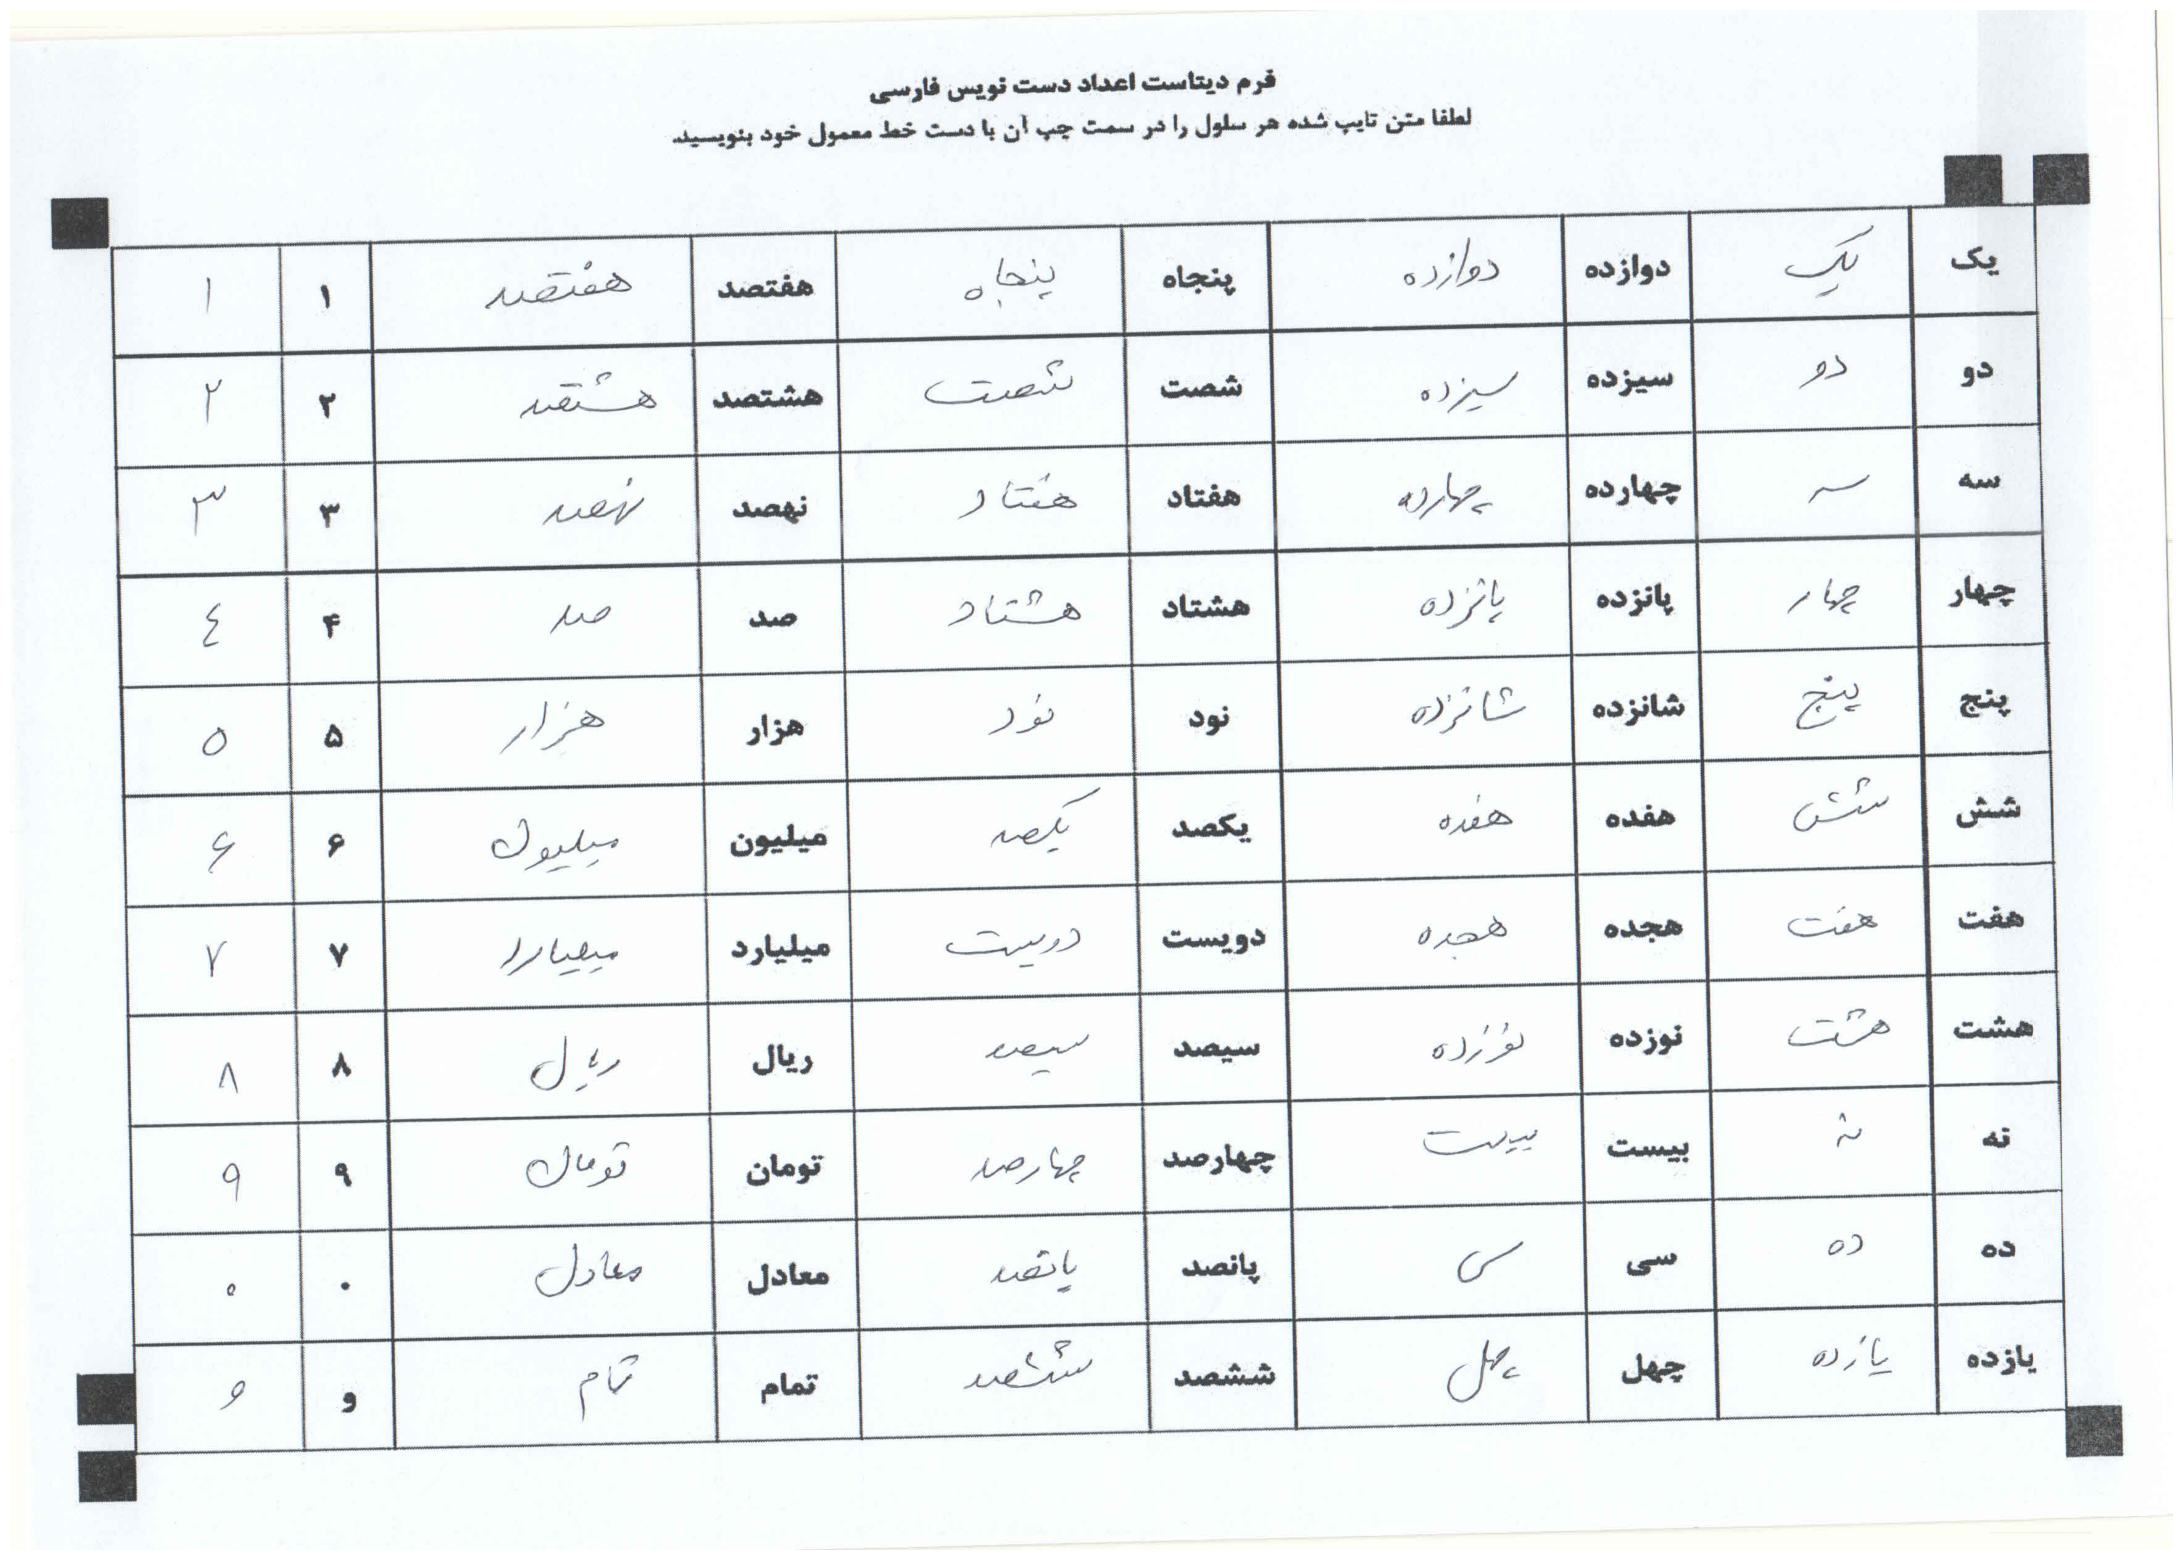

In [68]:
img = cv2.imread(str(df['path'][0]))
cv2_imshow(img)

In [69]:
def get_paper_eyes(img_org, img):
    threshold, img = cv2.threshold(img, 210, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((10, 10), np.uint8)
    img = cv2.erode(img, kernel)

    contours, h = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    preview_img = np.expand_dims(img, axis=-1).repeat(3, axis=-1)
    # cv2.drawContours(preview_img, contours, -1,(0,255,0),3)

    paper_eyes = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # print(x, y, w, h)
        if w > 30 and h > 30:
            cv2.drawContours(preview_img, [cnt], 0, (0, 215, 255), 3)
            paper_eyes.append((x, y, w, h))

    # cv2_imshow(preview_img)
    paper_eyes = np.array(paper_eyes)
    return paper_eyes

In [70]:
def dist(a):
    return np.sqrt(a[:, 0] ** 2 + a[:, 1] ** 2)

In [71]:
def crop_paper_eyes(img_path):
    img_org = cv2.imread(str(img_path))
    img = cv2.imread(str(img_path), 0)

    paper_eyes = get_paper_eyes(img_org, img)

    height, width = img.shape
    topleft_mask = np.logical_and(
        paper_eyes[:, 0] < width // 2, paper_eyes[:, 1] < height // 2
    )
    topright_mask = np.logical_and(
        paper_eyes[:, 0] > width // 2, paper_eyes[:, 1] < height // 2
    )
    bottomright_mask = np.logical_and(
        paper_eyes[:, 0] > width // 2, paper_eyes[:, 1] > height // 2
    )
    bottomleft_mask = np.logical_and(
        paper_eyes[:, 0] < width // 2, paper_eyes[:, 1] > height // 2
    )

    input_all = np.float32(
        [
            paper_eyes[topleft_mask][paper_eyes[topleft_mask][:, 0].argmin()].ravel(),
            paper_eyes[topright_mask].ravel(),
            paper_eyes[bottomright_mask][
                paper_eyes[bottomright_mask][:, 1].argmax()
            ].ravel(),
            paper_eyes[bottomleft_mask].ravel(),
        ]
    )
    input_ = np.float32(
        [
            paper_eyes[topleft_mask][paper_eyes[topleft_mask][:, 0].argmin()].ravel()[:2],
            paper_eyes[topright_mask].ravel()[:2],
            paper_eyes[bottomright_mask][
                paper_eyes[bottomright_mask][:, 1].argmax()
            ].ravel()[:2],
            paper_eyes[bottomleft_mask].ravel()[:2],
        ]
    )
    input_[0][0] += input_all[0][2]
    input_[0][1] += input_all[0][3]
    input_[1][1] += input_all[1][3]
    input_[3][0] += input_all[3][2]
    output_ = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])

    transform_matrix = cv2.getPerspectiveTransform(input_, output_)
    preview_img = cv2.warpPerspective(
        img_org,
        transform_matrix,
        (width, height),
        cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0),
    )
    # cv2_imshow(preview_img)
    return preview_img

In [72]:
blue_range = np.array([[128, 255, 255], [90, 50, 70]])

In [73]:
labels = [
    'word_1', 'word_12', 'word_50', 'word_700', 'digit_1',
    'word_2', 'word_13', 'word_60', 'word_800', 'digit_2',
    'word_3', 'word_14', 'word_70', 'word_900', 'digit_3',
    'word_4', 'word_15', 'word_80', 'word_100', 'digit_4',
    'word_5', 'word_16', 'word_90', 'word_1k', 'digit_5',
    'word_6', 'word_17', 'word_1sad', 'million', 'digit_6',
    'word_7', 'word_18', 'word_200', 'miliard', 'digit_7',
    'word_8', 'word_19', 'word_300', 'rial', 'digit_8',
    'word_9', 'word_20', 'word_400', 'toman', 'digit_9',
    'word_10', 'word_30', 'word_500', 'moadel', 'digit_0',
    'word_11', 'word_40', 'word_600', 'tamam', 'and',
]
print(len(labels))

55


In [74]:
# for label in labels:
#     os.makedirs(f'{processed_path}/{label}', exist_ok=True)

In [75]:
def extract_cells(img):
    width, height, _ = img.shape
    vpeaks = find_peaks(
        cv2.bitwise_not(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)).sum(axis=0),
        height=200000,
    )[0]
    vpeaks = [0] + sorted(vpeaks) + [width]
    hpeaks = find_peaks(
        cv2.bitwise_not(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)).sum(axis=1),
        height=200000,
    )[0]
    hpeaks = [0] + sorted(hpeaks) + [height]

    results = []
    for vidx in np.arange(len(vpeaks)):
        for hidx in np.arange(len(hpeaks)):
            if hidx < len(hpeaks) - 1 and vidx < len(vpeaks) - 1 and hpeaks[hidx + 1] - hpeaks[hidx] > 50:
                part_img = img[
                    hpeaks[hidx] : hpeaks[hidx + 1], vpeaks[vidx] : vpeaks[vidx + 1]
                ]
                results.append(part_img)

    results = results[0:-1:2]

    # crop to remove boarders
    results = [result[40:-10, 5:-20] for result in results]
    # reverse order
    results = results[::-1]
    # remove empty images
    results = [result for result in results if np.sum(result) > 0]
    return results

In [76]:
def crop_to_content(img):
    h = img.sum(axis=1)
    v = img.sum(axis=0)
    v = v>0
    h = h>0
    hargwhere = np.argwhere(h)
    vargwhere = np.argwhere(v)
    return img[
        hargwhere.min():hargwhere.max(), vargwhere.min():vargwhere.max()]

In [77]:
# timestamp = time.now()
# for img_table in df['path']:
#     print(img_table)
#     img_table = crop_paper_eyes(img_table)
#     extracted_data = extract_cells(img_table)
#     # cv2_imshow(extracted_data[-2])
#     for idx, (word, label) in enumerate(zip(extracted_data, labels)):
#         path = f'{processed_path}/{label}/'
#         # get list of items and sort them get max + 1
#         available_ids = [int(item.split('.')[0]) for item in os.listdir(path)]
#         if len(available_ids) > 0:
#             new_idx = max(available_ids) + 1
#         else:
#             new_idx = 0
#         cv2.imwrite(f'{path}/{new_idx}.jpg', word)
# print(f'Done in {time.now() - timestamp} seconds')

In [94]:
timestamp = time.now()
# for img_table in df['path'].iloc[:1]:
for img_table in df['path']:
    img_table_path = img_table 
    print(img_table_path)
    try:
        img_table = crop_paper_eyes(img_table)
    except Exception as e:
        print(f'Error: {e}')
        continue
    extracted_data = extract_cells(img_table)
    # cv2_imshow(extracted_data[-2])
    for idx, (word, label) in enumerate(zip(extracted_data, labels)):
        # path = f'{processed_path}/{label}/'
        path = f'{processed_path}'
        # get list of items and sort them get max + 1
        # available_ids = [int(item.split('.')[0]) for item in os.listdir(path)]
        available_ids = [int(item.split('.')[0].split('_')[-1]) for item in os.listdir(path)]
        if len(available_ids) > 0:
            new_idx = max(available_ids) + 1
        else:
            new_idx = 0
        
        mask = cv2.inRange(word, (230, 230, 230), (255, 255, 255)).astype(bool)
        
        # counts, bins = np.histogram(word[:, :, 0][~mask].ravel())
        # plt.hist(bins[:-1], bins, weights=counts, facecolor='b', alpha=0.5)
        # counts, bins = np.histogram(word[:, :, 1][~mask].ravel())
        # plt.hist(bins[:-1], bins, weights=counts, facecolor='g', alpha=0.5)
        # counts, bins = np.histogram(word[:, :, 2][~mask].ravel())
        # plt.hist(bins[:-1], bins, weights=counts, facecolor='r', alpha=0.5)
        
        
        # cv2_imshow(part_img)
        # TODO: Check if color is not blue drop it!
        
        part_img = word
        hsv = cv2.cvtColor(part_img, cv2.COLOR_BGR2HSV)
        bluepenMask = cv2.inRange(hsv, blue_range[1], blue_range[0])
        morphKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        # Perform closing:
        opIterations = 2
        bluepenMask = cv2.morphologyEx(
            bluepenMask,
            cv2.MORPH_OPEN,
            morphKernel,
            None,
            None,
            opIterations,
            cv2.BORDER_REFLECT101,
        )
        bluepenMask = cv2.morphologyEx(bluepenMask, cv2.MORPH_CLOSE, morphKernel, None, None, opIterations, cv2.BORDER_REFLECT101)

        part_img = cv2.bitwise_and(part_img, part_img, mask=bluepenMask)
        part_img = cv2.cvtColor(part_img, cv2.COLOR_BGR2GRAY)
        th, threshed = cv2.threshold(part_img, 10, 255, cv2.THRESH_BINARY)
        # cv2_imshow(threshed)
        # print(label)
        # cv2_imshow(crop_to_content(threshed))

        # cv2.imwrite(f'{path}/{new_idx}.jpg', word)
        title = f'{path}/{label}_{str(img_table_path).split("/")[-1].split(".")[0]}_{new_idx}.jpg'
        cv2.imwrite(title, threshed)
# print(f'Done in {time.now() - timestamp} seconds')

backup/1.jpg
backup/2.jpg
backup/3.jpg
backup/4.jpg
backup/5.jpg
backup/6.jpg
backup/7.jpg
backup/8.jpg
backup/9.jpg
backup/10.jpg
backup/11.jpg
backup/12.jpg
backup/13.jpg
backup/14.jpg
backup/15.jpg
backup/16.jpg
backup/17.jpg
backup/18.jpg
backup/19.jpg
backup/20.jpg
backup/21.jpg
backup/22.jpg
backup/23.jpg
backup/24.jpg
backup/25.jpg
backup/26.jpg
backup/27.jpg
backup/28.jpg
backup/29.jpg
backup/30.jpg
backup/31.jpg
backup/32.jpg
backup/33.jpg
backup/34.jpg
backup/35.jpg
backup/36.jpg
backup/37.jpg
backup/38.jpg
backup/39.jpg
backup/40.jpg
backup/41.jpg
backup/42.jpg
backup/43.jpg
backup/44.jpg
backup/45.jpg
backup/46.jpg
backup/47.jpg
backup/48.jpg
backup/49.jpg
backup/50.jpg
backup/51.jpg
backup/52.jpg
backup/53.jpg
backup/54.jpg
backup/55.jpg
backup/56.jpg
backup/57.jpg
backup/58.jpg
backup/59.jpg
backup/60.jpg
backup/61.jpg
backup/62.jpg
backup/63.jpg
backup/64.jpg
backup/65.jpg
backup/66.jpg
backup/67.jpg
backup/68.jpg
backup/69.jpg
backup/70.jpg
backup/71.jpg
backup/72.jpg
b

KeyboardInterrupt: 

In [81]:
plt.close('all')